# 6 Object Detection
- Template matching
- Corner detection
- Edge Detection
- Grid detection
- Contour detection
- Feature matching: most advanced method
- Watershed
- Facial and eye detection with Haar cascades
- Project: blurring license plates

## 6.6 Feature Matching

In **template matching**, we needed to have the exact image to find. Now, we extract features from the image (corners, edges, contours, etc.) and try to match them. Thus, the search image doesn't have to contain the exact image being looked for.

**Feature vectors** are defined and a distance metric between them is defined to find matching patterns.

Three methods tested:
1. Brute-Force matching with ORB-descriptors (worst result)
2. Brute-Force matching with SIFT descriptors and ratio test (good result)
3. FLANN-based matching with SIFT descriptors and ratio test + Visualization Params & Mask (good result + fast)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

In [9]:
reeses = cv2.imread('../../data/reeses_puffs.png',0)

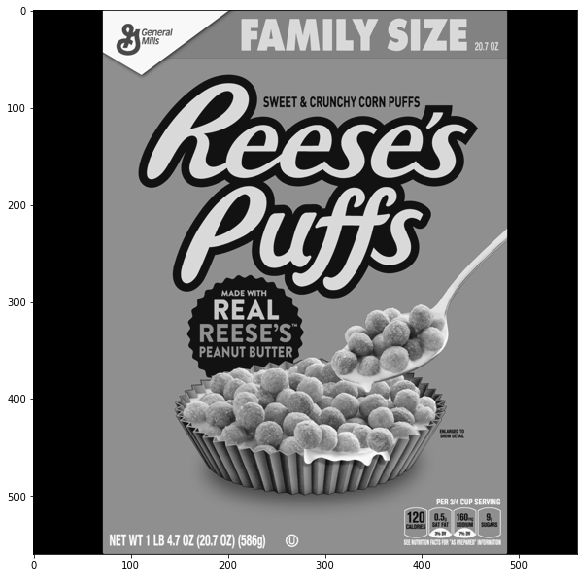

In [10]:
display(reeses)

In [11]:
cereals = cv2.imread('../../data/many_cereals.jpg',0)

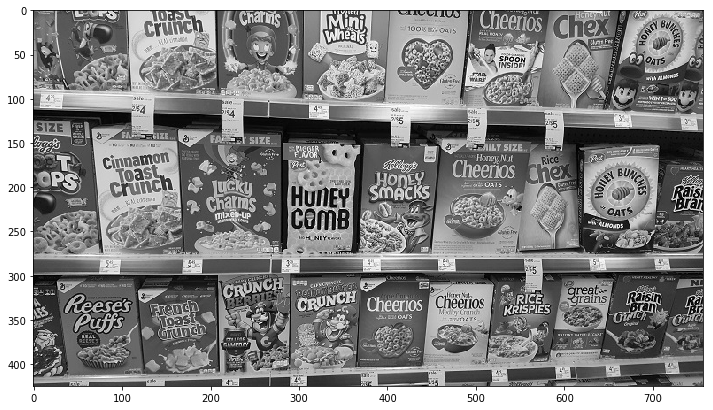

In [12]:
display(cereals)

**IMPORTANT NOTE**: Our template image is not a photograph, but a package front image to be printed; in addition, it has the banner "FAMILY SIZE" on it -- in the supermarket aisle image several packages have that banner and the packages have a viewpoint distortion.

### 6.6.1 Brute-force with ORB (worst result)

In [13]:
orb = cv2.ORB_create()

In [15]:
# input: template/search image and mask (None in our case)
# output: ORB keypoints, ORB descriptors = feature vectors
kp1,des1 = orb.detectAndCompute(reeses,None)
kp2,des2 = orb.detectAndCompute(cereals,None)

In [16]:
# Brute-force matcher object
# Method to use: cv2.NORM_HAMMING
bf = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)

In [17]:
matches = bf.match(des1,des2)

In [20]:
# matches is a list of matching objects
single_match = matches[0]

In [23]:
# each object has several fields/attributes
# the field distance is very important: it accounts for the quality: the smaller the distance, the better the match
single_match.distance

69.0

In [25]:
# we order the matching objects according to their distance
matches = sorted(matches, key=lambda x:x.distance)

In [27]:
# we have 250+ matches, probably
len(matches)

263

In [35]:
# input:
# - template image + ORB keypoints
# - search image + ORB keypoints
# - matches list: since they are 250+, we take the best 25 for visu
# - mask: None
# - flags: how to draw the matches; 0: all keypoints + matches with lines, 2: matches with lines
# output: image in which both template and search image are stitched and matches are displayed in color
reeses_matches = cv2.drawMatches(reeses, kp1, cereals, kp2, matches[:25],None,flags=2)

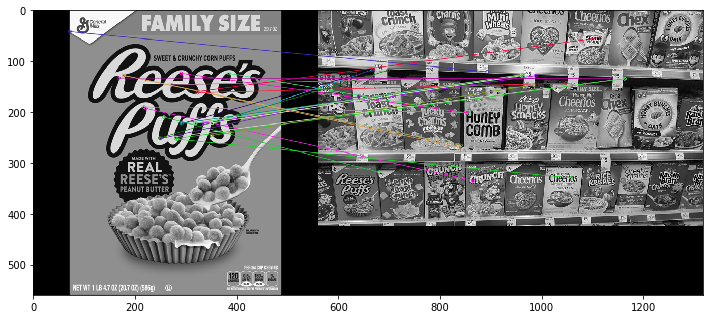

In [36]:
display(reeses_matches)

**IMPORTANT**: We see that the result is not that good... That's because of these reasons:
- The packages in the search images are quite similar / have similar features
- Our template image has the banner "FAMILY SIZE", not present in the search image
- The banner "FAMILY SIZE" appears on other packages

### 6.6.2 Brute-force with SIFT and ratio test (good result)

SIFT = Scale Invariant Feature Transform. It works nice when scaling changes.

In [37]:
sift = cv2.xfeatures2d.SIFT_create()

In [39]:
# same interface as before:
# input: template/search image and mask (None in our case)
# output: SIFT keypoints, SIFT descriptors = feature vectors
kp1,des1 = sift.detectAndCompute(reeses,None)
kp2,des2 = sift.detectAndCompute(cereals,None)

In [45]:
# descriptors found in template/query image
len(des1)

1500

In [49]:
# descriptors found in search/train image
len(des2)

3744

In [50]:
bf = cv2.BFMatcher()

In [51]:
# knnMatch: given the template/query descriptors (des1), find the k best matches for it
matches = bf.knnMatch(des1, des2, k=2)

In [52]:
len(matches)

1500

In [59]:
# matches contains the k=2 best matches for each descriptor from the query/template image
# the first in a pair is better (smaller distance) than the next
matches[:10]

[[<DMatch 0x7f9821c93770>, <DMatch 0x7f9822ab95f0>],
 [<DMatch 0x7f9822ab9670>, <DMatch 0x7f9822ab9610>],
 [<DMatch 0x7f9822ab96b0>, <DMatch 0x7f9822ab95b0>],
 [<DMatch 0x7f9822ab9550>, <DMatch 0x7f9822ab9630>],
 [<DMatch 0x7f9822ab95d0>, <DMatch 0x7f9822ab96d0>],
 [<DMatch 0x7f9822ab96f0>, <DMatch 0x7f9822ab9710>],
 [<DMatch 0x7f9822ab9730>, <DMatch 0x7f9822ab9750>],
 [<DMatch 0x7f9822ab9770>, <DMatch 0x7f9822ab9790>],
 [<DMatch 0x7f9822ab97b0>, <DMatch 0x7f9822ab97d0>],
 [<DMatch 0x7f9822ab97f0>, <DMatch 0x7f9822ab9810>]]

In [63]:
# in practice, if both matches have a similar distance to the descriptor, that's good:
# that means the descriptor has close matching candidates (it's a heuristic)
# we apply that notion and perform distance ratio selection
# recall: better macthes have smaller distance attribute
good_matches = []
for m1,m2 in matches:
    if m1.distance < 0.75*m2.distance:
        # descriptor is good, we take its match object
        good_matches.append([m1]) # IMPORTANT: we need to instert it as a list!

In [64]:
# now, we have much less matches and they are expected to be good
len(good_matches)

78

In [65]:
sift_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good_matches, None, flags=2)

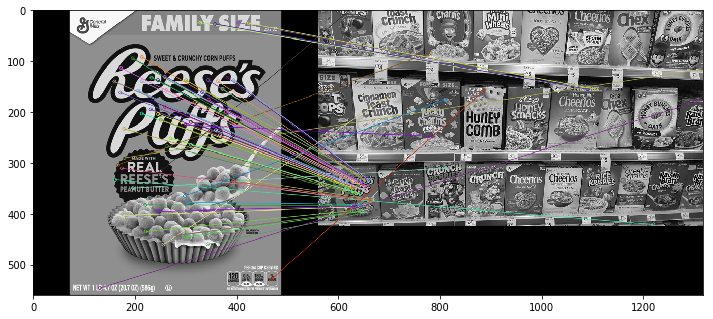

In [67]:
display(sift_matches)

**IMPORTANT CONCLUSION**: The results are much better now.

### 6.6.3 FLANN-based matches with SIFT and ratio test + Visualization Params & Mask (good result + fast)

Here, instead of using brute-force search, we use FLANN search. FLANN is much faster, but it delivers approximately best matches, not the optimum matches. The rest is basically as in the brute-force SIFT.

In [68]:
sift = cv2.xfeatures2d.SIFT_create()

In [69]:
# same interface as before:
# input: template/search image and mask (None in our case)
# output: SIFT keypoints, SIFT descriptors = feature vectors
kp1,des1 = sift.detectAndCompute(reeses,None)
kp2,des2 = sift.detectAndCompute(cereals,None)

In [74]:
# FLANN = Fast Library for Approximate Nearest Neighbors
# Using FLANN is much faster than brute force, but it doesn't provide best matches, but some good matches (RANSAC in it?)
# FLANN parameters, default values (we can tune them)
FLANN_INDEX_KDTREE = 0
index_params = {'algorithm':FLANN_INDEX_KDTREE, 'trees':5}
search_params = {'checks':50}

In [87]:
# Instead of the Brute-Force matcher, we use the Flann matcher
flann = cv2.FlannBasedMatcher(index_params, search_params)

From now on, everything would be the same as before, but we use masks as additional feature.

In [90]:
matches = flann.knnMatch(des1, des2, k=2)

In [92]:
# We create an empty mask list
matchesMask = [[0,0] for i in range(len(matches))]

In [94]:
#matchesMask

In [100]:
# We set the first element of the mask pair to 1 if the consecutive distances are OK
#good_matches = []
for i,(m1,m2) in enumerate(matches):
    if m1.distance < 0.75*m2.distance:
        #good_matches.append([m1])
        matchesMask[i] = [1,0]

In [110]:
# Dictionary for assiging colors to keypoints and lines according to mask
draw_params = dict(matchColor=(0,255,0),
                  singlePointColor=(255,0,0),
                  matchesMask=matchesMask,
                  flags=0) # if 2, only lines drwan

In [111]:
# Instead of good points, we pass all matches and the dictionary with drawing parameters
#flann_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, good_matches, None, flags=0)
flann_matches = cv2.drawMatchesKnn(reeses, kp1, cereals, kp2, matches, None, **draw_params)

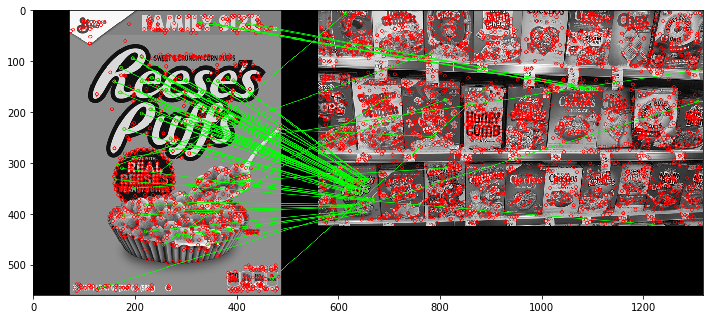

In [112]:
display(flann_matches)

Similar results as before.